# King County House Sales Regression Analysis

Student name: Rebecca Chu

## Overview

This project utilises an iterative approach to building a multiple linear regression model.

## Business Problem

* Which features of a house correlate with a higher price point?
* What renovations would we recommend to increase the value of a house? (predictive) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statistics as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from geopy.distance import geodesic as GD

## Data Understanding
### King County House Sales

This analysis explores the King County House Sales data, which was provided for this project. The dataset provided property information for 21,597 houses that were sold between May 2014 and May 2015. The target variable is house sale prices.

For the description of the column names please refer to `column_names.md` in the `data` folder.

In [2]:
kc = pd.read_csv('./data/kc_house_data.csv')
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Data Preparation
### 1. Data Cleaning

#### 1.1. Converting Datatypes

In [3]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

We can see that the majority of columns are numerical datatypes, with the exception of `date` and `sqft_basement`, which are object datatypes. As I am interested in the relationship between the target variable and the time of year the house was sold, I converted `date` into a datetime datatype.

In [4]:
# converting date to datetime datatype
kc.date = pd.to_datetime(kc.date)

# descriptive statistics for date Series
kc.date.describe()

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

In [5]:
# adding a new column for month sold
kc['month_sold'] = kc.date.dt.month

In [6]:
# adding a new column for age of house at the time of sell
kc['age'] = kc.date.dt.year - kc.yr_built

I also wanted to take a look at the relationship between location and price. I generated a 'map' of King County by plotting each house according their coordinates. 

I also marked where Seattle and Bellevue were, the largest and second largest cities of the county by population total respectively. The `o` marks Seattle, `x` marks Bellevue.

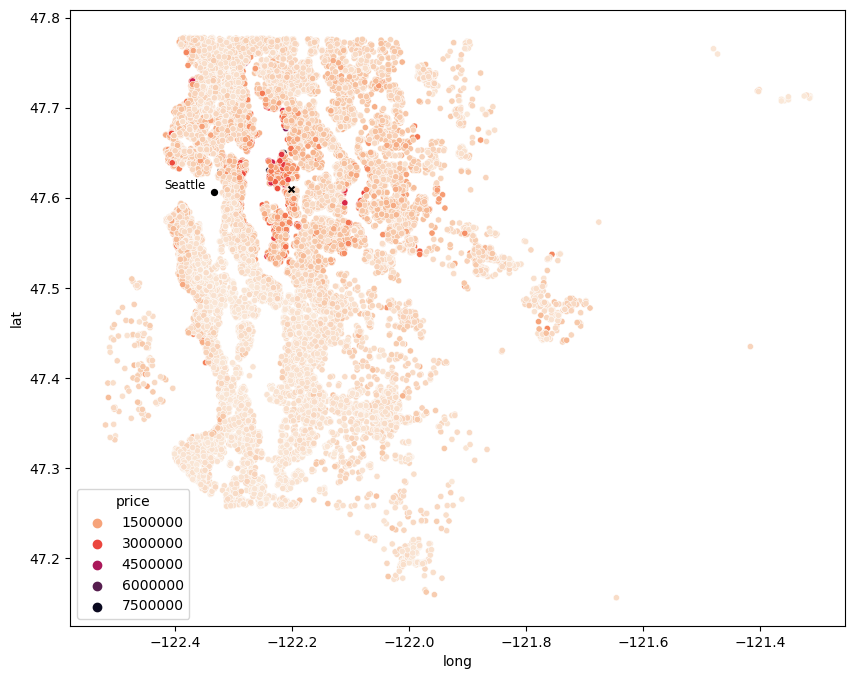

In [7]:
# plotting houses according to latitude and longitude
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=kc.long, y=kc.lat, hue=kc.price, s=20, palette='rocket_r')

plt.scatter(-122.3328, 47.6061, marker='o', color='black', s=18)
plt.scatter(-122.2015, 47.6101, marker='x', color='black', s=18)
plt.text(-122.418, 47.6101, 'Seattle', fontsize='small');

We can see that the price tends to increase closer to the city, in particular Bellevue. I decided to add a variable measuring the distance of the house from each city.

In [8]:
# adding a new column for coordinates of house
kc['coordinates'] = list(zip(kc.lat, kc.long))

In [9]:
# inputing coordinates for Seattle and Bellevue
Seattle = (47.6061, -122.3328)
Bellevue = (47.6101, -122.2015)

dist_seattle = []
dist_bellevue = []

for i in range(len(kc.coordinates)):
    dist_seattle.append(GD(Seattle, kc.coordinates[i]).km)

for i in range(len(kc.coordinates)):
    dist_bellevue.append(GD(Bellevue, kc.coordinates[i]).km)

kc['dist_seattle'] = dist_seattle
kc['dist_bellevue'] = dist_bellevue

Note that `geopy` measures the straight-line distance between two points and the measurement should only be used as a guide. The distance/ time it takes to travel into the cities may vary greatly depending road accessibility.

#### 1.2. Dropping Irrelevant Columns

I then dropped columns that were irrelevant to my analysis. 

I chose to focus on the grade and condition of the house over the year built or renovated. I also chose to focus on the geographical position of the house (latitude and longtitude) rather than zipcode.

In [10]:
# dropping irrelevant columns
kc.drop(['id', 'date', 'view', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'coordinates'], 
        axis=1, inplace=True)

#### 1.3. Dealing with Missing Values and Removing Nulls

In [11]:
# checking for nulls
kc.isna().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront        True
condition        False
grade            False
sqft_above       False
lat              False
long             False
month_sold       False
age              False
dist_seattle     False
dist_bellevue    False
dtype: bool

In [12]:
# confirming the number of nulls present
kc.waterfront.value_counts(dropna=False)

waterfront
0.0    19075
NaN     2376
1.0      146
Name: count, dtype: int64

In [13]:
# confirming the percentage of each value within the waterfront column
waterfront_counts = kc.waterfront.value_counts(dropna=False)
(waterfront_counts/len(kc))*100

waterfront
0.0    88.322452
NaN    11.001528
1.0     0.676020
Name: count, dtype: float64

We can see that only one column contains null values: `waterfront`. Given that only 0.7% of house have a view to a watefront (vs. 88% that do not), I decided to replace the missing values with 0.

In [14]:
# replacing all NaN values with 0
kc.waterfront.fillna(0, inplace=True)

# confirming no nulls 
kc.isna().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
condition        False
grade            False
sqft_above       False
lat              False
long             False
month_sold       False
age              False
dist_seattle     False
dist_bellevue    False
dtype: bool

The final dataset I will be using to build the model includes the following predictors:

* Number of bedrooms
* Number of bathrooms
* Square footage of the home
* Square footage of the lot
* Floors
* Whether the house has a view to a waterfront
* Condition
* Grade
* Square footage of the house (excluding the basement)
* Latitude
* Longitude
* Month sold
* Age
* Distance to Seattle (in km)
* Distance to Bellevue (in km)

In [15]:
kc.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,47.5112,-122.257,10,59,11.994583,11.762420
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,47.7210,-122.319,12,63,12.816995,15.162997
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,47.7379,-122.233,2,82,16.459384,14.404860
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,47.5208,-122.393,12,49,10.510256,17.499539
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,47.6168,-122.045,2,28,21.670615,11.789400


### Train Test Split

To avoid data leakage, I split the dataset into a train and test set. 

In [16]:
X = kc.drop('price', axis=1)
y = kc['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

#### 1.4. Dealing with Outliers

In [17]:
X_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
count,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00,16197.00
mean,3.37,2.12,2078.66,15083.99,1.50,0.01,3.41,7.66,1788.89,47.56,-122.21,6.59,43.37,18.45,17.25
std,0.93,0.77,921.85,40159.78,0.54,0.08,0.65,1.17,830.84,0.14,0.14,3.11,29.43,10.64,9.06
min,1.00,0.50,380.00,520.00,1.00,0.00,1.00,4.00,380.00,47.16,-122.52,1.00,-1.00,1.04,0.26
25%,3.00,1.50,1420.00,5040.00,1.00,0.00,3.00,7.00,1190.00,47.47,-122.33,4.00,17.00,9.78,11.29
50%,3.00,2.25,1910.00,7607.00,1.50,0.00,3.00,7.00,1560.00,47.57,-122.23,6.00,40.00,16.50,15.20
75%,4.00,2.50,2550.00,10665.00,2.00,0.00,4.00,8.00,2210.00,47.68,-122.12,9.00,63.00,25.27,21.19
max,33.00,8.00,13540.00,1164794.00,3.50,1.00,5.00,13.00,9410.00,47.78,-121.31,12.00,115.00,77.37,67.56


From the above, we can see that the maximum number of bedrooms is 33, which is significantly higher than the median. We can look at the distribution of the bedroom variable to assess the impact of outliers.

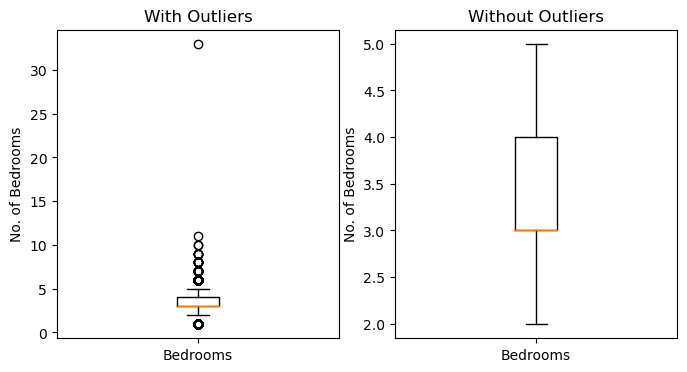

In [18]:
# generating boxplots for bedroom with and without outliers 
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].boxplot(X_train.bedrooms)
axes[1].boxplot(X_train.bedrooms, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Bedrooms")
axes[1].set_xlabel("Bedrooms")
axes[0].set_ylabel("No. of Bedrooms")
axes[1].set_ylabel("No. of Bedrooms")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False);

From the boxplots above, we can see a few outliers with more than five bedrooms. So that these outliers do not skew our model and we focus on building a model with the highest accuracy for the majority of homes, I will be focusing on houses with five bedrooms or less.

In [19]:
# removing houses with more than five bedrooms 
X_train = X_train[X_train.bedrooms < 6]

Taking a look at the distribution of bathrooms also reveals a few outliers, which I have also decided to remove.

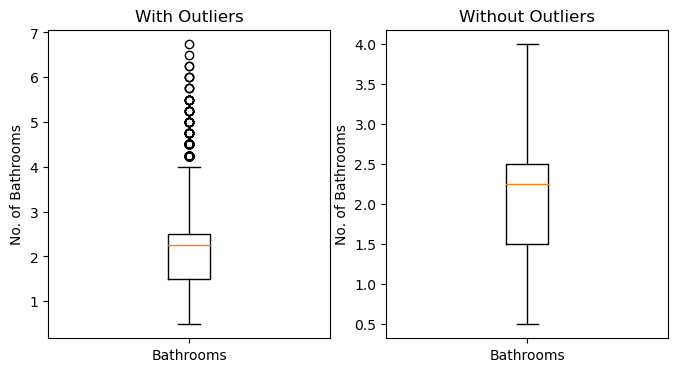

In [20]:
# generating boxplots for bathrooms with and without outliers 
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].boxplot(X_train.bathrooms)
axes[1].boxplot(X_train.bathrooms, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Bathrooms")
axes[1].set_xlabel("Bathrooms")
axes[0].set_ylabel("No. of Bathrooms")
axes[1].set_ylabel("No. of Bathrooms")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False);

In [21]:
# removing houses with more than four bathrooms 
X_train = X_train[X_train.bedrooms < 5]

### 2. Categorical Variables
#### 2.1. Identifying Categorical Variables

From our descriptive statistics using `.describe()`, we can see that bedrooms, bathrooms, floors, waterfront, condition, and grade, have values with a limited range, which suggests that they represent categorical variables. 

To confirm which columns represent categorical variables, I used scatter plots to identify which variables generated vertical lines (signifying discrete values). So that I can plot the predictors as a function of price, I have used the original dataset `kc`.

We also know that `month_sold` and `zipcodes` represent categorical data.

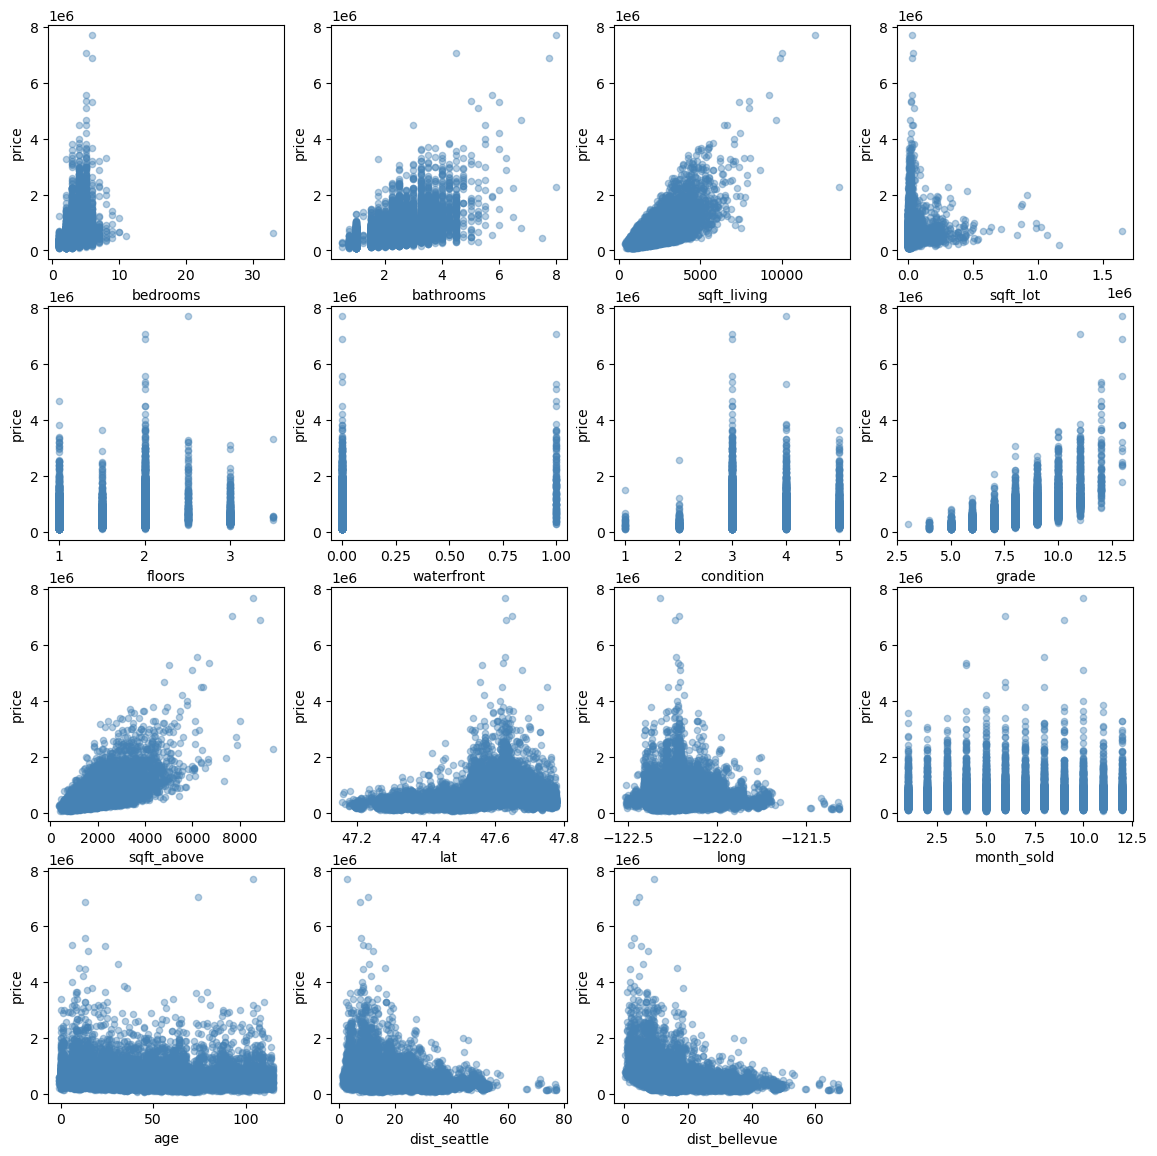

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14,14))

# delete empty subplots
fig.delaxes(axes[3,3])

predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'lat', 
              'long', 'month_sold', 'age', 'dist_seattle', 'dist_bellevue']

for xcol, ax in zip(predictors, axes.flatten()): 
    kc.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='steelblue');

From the scatter plots above, we can see that bedrooms, bathrooms, floors, waterfront, condition, and grade clearly represent categorical variables.

We can also see that sqft_living and sqft_above appear to have a positive linear relationship with price, and dist_seattle and dist_bellevue may have a negative linear relationship with price.

#### 2.2. Creating Dummy Variables

In [23]:
def create_dummy(cat, df):
    '''
    Function takes a categorical Series and a dataframe and returns dummy variables using get_dummies().
    '''
    return pd.get_dummies(df[f'{cat}'], prefix=f'{cat}', dtype=float, drop_first=True)

In [24]:
# creating dummy variables
room_dummies = create_dummy('bedrooms', X_train)
bath_dummies = create_dummy('bathrooms', X_train)
flr_dummies = create_dummy('floors', X_train)
water_dummies = create_dummy('waterfront', X_train)
cond_dummies = create_dummy('condition', X_train)
grade_dummies = create_dummy('grade', X_train)
month_dummies = create_dummy('month_sold', X_train)

# removing original columns from dataset
X_train_preprocessed = X_train.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'month_sold'], 
                                    axis=1)

# concating dummy columns into dataset
X_train_preprocessed = pd.concat([X_train_preprocessed, room_dummies, bath_dummies, flr_dummies, water_dummies, 
                             cond_dummies, grade_dummies, month_dummies], axis=1)
X_train_preprocessed.head()

,sqft_living,sqft_lot,sqft_above,lat,long,age,dist_seattle,dist_bellevue,bedrooms_2,bedrooms_3,...,month_sold_3,month_sold_4,month_sold_5,month_sold_6,month_sold_7,month_sold_8,month_sold_9,month_sold_10,month_sold_11,month_sold_12
1673,1600,9289,1600,47.3107,-122.212,55,34.082218,33.296651,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20513,1950,2457,1950,47.5925,-122.302,5,2.766078,7.806675,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20888,1690,1321,1320,47.6780,-122.117,1,18.078686,9.864265,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16050,3010,6181,3010,47.5212,-122.192,14,14.190369,9.909886,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12519,1830,4500,1830,47.6760,-122.308,105,7.992010,10.849929,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 3. Multicollinarity

In [25]:
# creating a correlation matrix
X_train.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
bedrooms,1.000000,0.493357,0.565148,0.029099,0.207035,-0.017560,0.015785,0.394314,0.502625,-0.055253,0.193030,-0.000266,-0.226573,0.145816,0.012552
bathrooms,0.493357,1.000000,0.729042,0.088333,0.520945,0.049084,-0.130444,0.664875,0.667877,0.007751,0.247226,0.014696,-0.540096,0.121626,-0.024497
sqft_living,0.565148,0.729042,1.000000,0.179957,0.351710,0.099446,-0.063276,0.765135,0.877082,0.038706,0.267571,0.020487,-0.338080,0.114041,-0.069983
sqft_lot,0.029099,0.088333,0.179957,1.000000,-0.018415,0.023764,-0.019895,0.113396,0.191747,-0.088303,0.246625,-0.002028,-0.059849,0.255623,0.186270
floors,0.207035,0.520945,0.351710,-0.018415,1.000000,0.014502,-0.266918,0.459874,0.510672,0.052749,0.122015,0.017931,-0.511153,0.005084,-0.032423
waterfront,-0.017560,0.049084,0.099446,0.023764,0.014502,1.000000,0.016061,0.083903,0.060640,-0.014261,-0.037960,0.011357,0.021316,-0.009606,-0.005611
condition,0.015785,-0.130444,-0.063276,-0.019895,-0.266918,0.016061,1.000000,-0.145548,-0.157867,-0.004984,-0.107428,0.016649,0.355298,-0.073513,-0.045554
grade,0.394314,0.664875,0.765135,0.113396,0.459874,0.083903,-0.145548,1.000000,0.754647,0.112475,0.207872,0.019359,-0.457030,0.022705,-0.142593
sqft_above,0.502625,0.667877,0.877082,0.191747,0.510672,0.060640,-0.157867,0.754647,1.000000,-0.016409,0.371079,0.018353,-0.442084,0.229575,0.012406
lat,-0.055253,0.007751,0.038706,-0.088303,0.052749,-0.014261,-0.004984,0.112475,-0.016409,1.000000,-0.144697,0.020575,0.151510,-0.602682,-0.687853


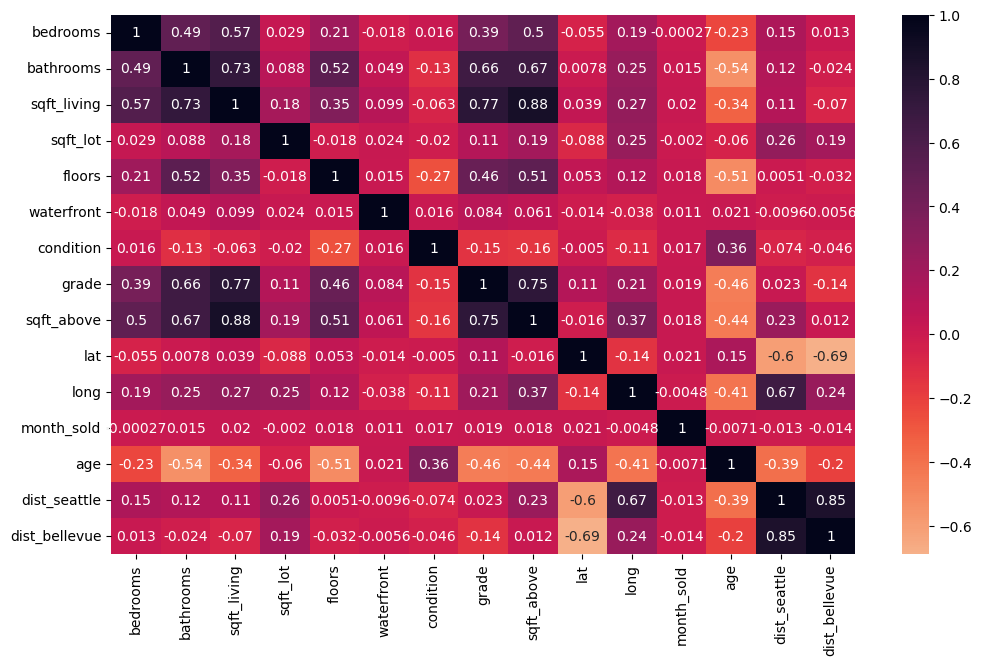

In [26]:
# visualising correlations
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(X_train.corr(), center=0, annot=True, cmap='rocket_r');

In [27]:
# saving absolute value of the correlation matrix as a data frame
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))
df.drop(columns=['level_1','level_0'], inplace=True)
df.set_index(['pairs'], inplace=True)
df.columns = ['cc']

In [28]:
df[(df.cc >.75) & (df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.877082
"(sqft_living, sqft_above)",0.877082
"(dist_seattle, dist_bellevue)",0.847554
"(dist_bellevue, dist_seattle)",0.847554
"(sqft_living, grade)",0.765135
"(grade, sqft_living)",0.765135
"(grade, sqft_above)",0.754647
"(sqft_above, grade)",0.754647


We can see that `sqft_living` and `sqft_above`, `grade` and `sqft_living`, and `dist_seattle` and `dist_bellevue`, are highly correlated with each other, so I decided to drop `sqft_living` and `dist_seattle` to avoid multicollinearity.

I chose to drop `dist_seattle` over `dist_bellevue` as the houses with a higher sale price were closer to Bellevue.

In [29]:
# dropping sqft_living and dist_seattle
X_train_preprocessed.drop(['sqft_living', 'dist_seattle'], axis=1, inplace=True)

## Model 1 

Baseline model

In [30]:
# checking the shape of our train data
X_train_preprocessed.shape

(14763, 60)

In [31]:
# checking the shape of our train data
y_train.shape

(16197,)

We can see that the shape of our `X_train` and `y_train` are no longer equal as we removed outliers from `X_train` only earlier. To rectify this, I joined `y_train` to `X_train_preprocessed` via a left join.

In [32]:
# joining X_train_preprocessed to y_train
trained_joined = X_train_preprocessed.join(y_train, how='left')

In [33]:
X = X_train_preprocessed
y = trained_joined['price']

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     615.4
Date:                Wed, 20 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:09:18   Log-Likelihood:            -1.9884e+05
No. Observations:               14763   AIC:                         3.978e+05
Df Residuals:                   14702   BIC:                         3.983e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.525e+07   1.68e+06     -9.074      0.000   -1.85e+07    -1.2e+07
sqft_lot           0.3027      0.039      7.843      0.000       0.227       0.378
sqft_above       100.4358      3.702     27.132      0.000      93.180     107.692
lat             2.171e+05   1.42e+04     15.242      0.000    1.89e+05    2.45e+05
long            -4.05e+04   1.22e+04     -3.318      0.001   -6.44e+04   -1.66e+04
age             2145.4869     79.465     26.999      0.000    1989.726    2301.247
dist_bellevue  -8332.8865    227.738    -36.590      0.000   -8779.281   -7886.492
bedrooms_2      -211.1088   1.51e+04     -0.014      0.989   -2.98e+04    2.93e+04
bedrooms_3     -9121.0075   1.51e+04     -0.604      0.546   -3.87e+04    2.05e+04
bedrooms_4     -1.415e+04   1.54e+04     -0.918      0.359   -4.44e+04    1.61e+04
bathrooms_0.75  1.346e+04   8.95e+04      0.150      0.880   -1.62e+05    1.89e+05
bathrooms_1.0    3.58e+04   8.59e+04      0.417      0.677   -1.33e+05    2.04e+05
bathrooms_1.25  1.048e+05   1.08e+05      0.973      0.331   -1.06e+05    3.16e+05
bathrooms_1.5   7.147e+04   8.61e+04      0.830      0.406   -9.73e+04     2.4e+05
bathrooms_1.75  9.052e+04    8.6e+04      1.052      0.293   -7.81e+04    2.59e+05
bathrooms_2.0    1.03e+05   8.61e+04      1.197      0.231   -6.57e+04    2.72e+05
bathrooms_2.25  1.317e+05   8.61e+04      1.530      0.126   -3.71e+04    3.01e+05
bathrooms_2.5   1.362e+05   8.61e+04      1.582      0.114   -3.26e+04    3.05e+05
bathrooms_2.75  1.621e+05   8.62e+04      1.880      0.060   -6953.531    3.31e+05
bathrooms_3.0   1.728e+05   8.64e+04      1.999      0.046    3337.803    3.42e+05
bathrooms_3.25  2.765e+05   8.66e+04      3.193      0.001    1.07e+05    4.46e+05
bathrooms_3.5   2.426e+05   8.65e+04      2.803      0.005     7.3e+04    4.12e+05
bathrooms_3.75  4.023e+05   8.87e+04      4.534      0.000    2.28e+05    5.76e+05
bathrooms_4.0   4.085e+05   8.93e+04      4.576      0.000    2.34e+05    5.83e+05
bathrooms_4.25  5.591e+05   9.09e+04      6.151      0.000    3.81e+05    7.37e+05
bathrooms_4.5   5.018e+05   9.16e+04      5.476      0.000    3.22e+05    6.81e+05
bathrooms_4.75  5.664e+05   1.12e+05      5.078      0.000    3.48e+05    7.85e+05
bathrooms_5.0   5.488e+05   1.08e+05      5.070      0.000    3.37e+05    7.61e+05
bathrooms_5.25  2.061e+05   1.22e+05      1.689      0.091   -3.31e+04    4.45e+05
bathrooms_5.5   9.625e+05   1.16e+05      8.273      0.000    7.34e+05    1.19e+06
bathrooms_5.75  2.132e+05   1.94e+05      1.098      0.272   -1.67e+05    5.94e+05
floors_1.5      3745.5733   5582.130      0.671      0.502   -7196.101    1.47e+04
floors_2.0     -3.395e+04   4569.356     -7.430      0.000   -4.29e+04    -2.5e+04
floors_2.5      7.419e+04   1.83e+04      4.052      0.000    3.83e+04     1.1e+05
floors_3.0  

### 4. Log Transformations

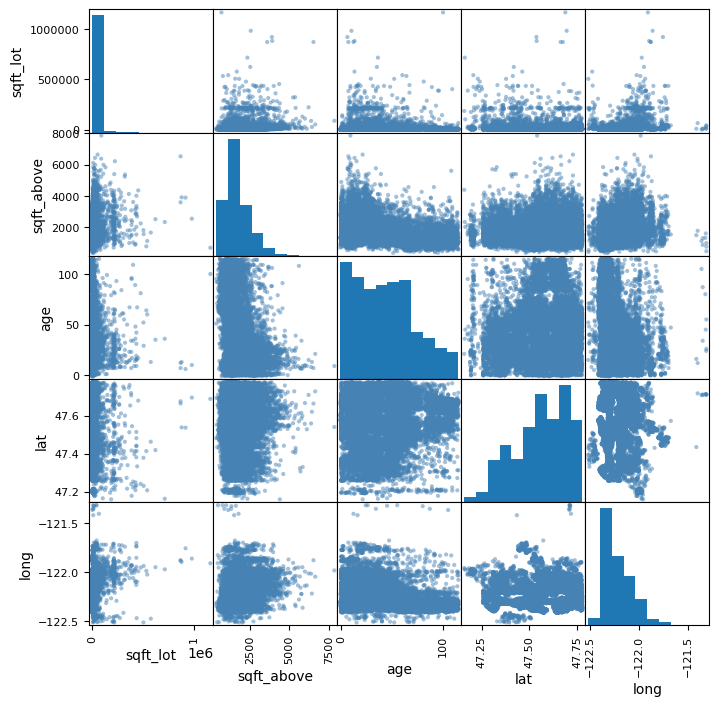

In [35]:
continuous = ['sqft_lot', 'sqft_above', 'age', 'lat', 'long']

# checking the distribution of continuous data 
pd.plotting.scatter_matrix(X_train[continuous], figsize=(8,8), color='steelblue');

## Model Validation

In [36]:
# transforming test data
X_test_preprocessed = pd.concat([X_test[continuous], pd.DataFrame(ohe.transform(X_test[cats]), index=X_test.index)], axis=1)

X_test_preprocessed.columns = X_test_preprocessed.columns.astype(str)

NameError: name 'ohe' is not defined

In [ ]:
linreg = LinearRegression()

linreg.fit(X, y)

In [ ]:
linreg.score(X, y)

In [ ]:
X_test_preprocessed.drop('sqft_living', axis=1, inplace=True)

In [ ]:
linreg.score(X_test_preprocessed, y_test)

In [ ]:
y_hat_train = linreg.predict(X)
y_hat_test = linreg.predict(X_test_preprocessed)

In [ ]:
train_mse = mean_squared_error(y, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

In [ ]:
np.sqrt(train_mse)

In [ ]:
np.sqrt(test_mse)

## Evaluation

In [ ]:
# assessing the accuracy of the waterfront variable
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=kc.long, y=kc.lat, hue=kc.waterfront, s=10, palette='Blues')
plt.scatter(-122.3328, 47.6061, marker='o', color='black', s=20)
plt.scatter(-122.2015, 47.6101, marker='x', color='black', s=20);